# Decision Trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from decision_tree import DecisionTree

np.random.seed(1)

## Regression Trees

In [2]:
#
# create dataset
#
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 100, 0.2)
X_train = x_train[:, None]
X_test = np.linspace(0, 1, 100)[:, None]
y_test = sinusoidal(X_test)[:, 0]

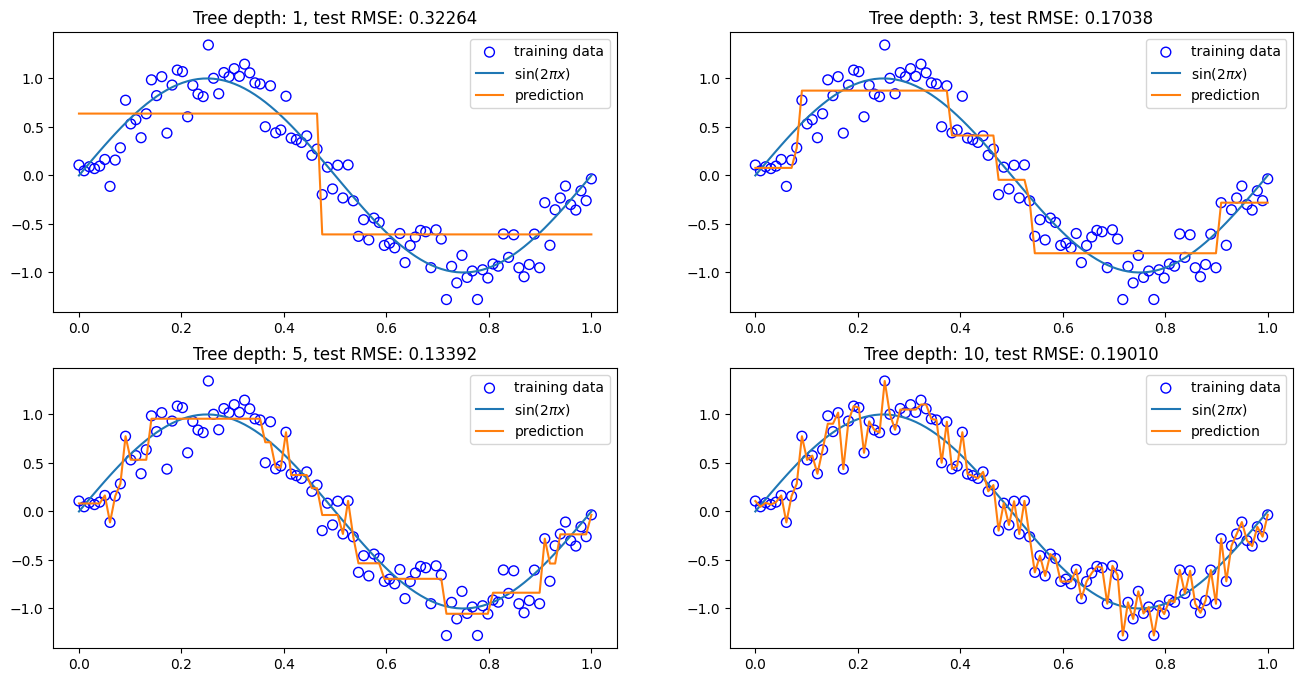

In [3]:
#
# tune model complexity through tree depth
#
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

for i, depth in enumerate([1, 3, 5, 10]):
    model = DecisionTree(criterion="squared_error", assign_leaf_node="mean", max_depth=depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(np.mean((preds - y_test)**2))

    row, col = divmod(i, 2)
    ax[row, col].set_title(f"Tree depth: {depth}, test RMSE: {rmse:.5f}")
    ax[row, col].scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    ax[row, col].plot(X_test, y_test, label="$\sin(2\pi x)$")
    ax[row, col].plot(X_test, preds, label="prediction")
    ax[row, col].legend()

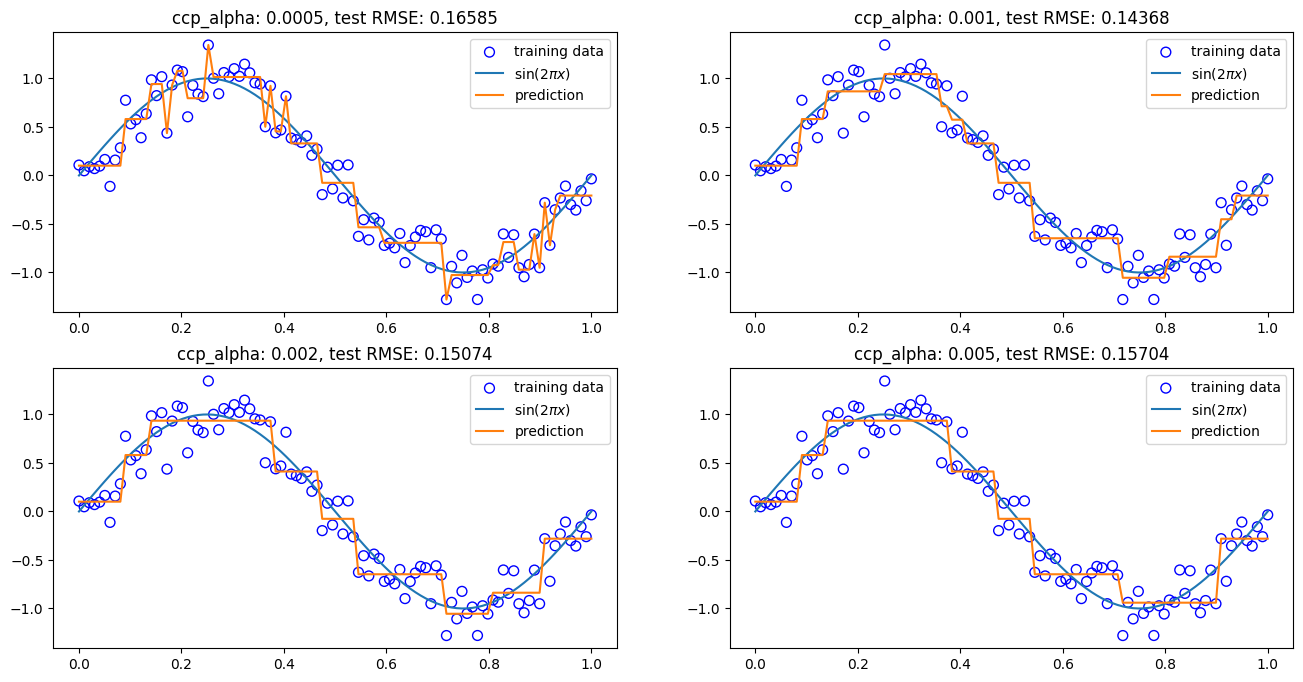

In [4]:
#
# tune model complexity through minimal cost-complexity pruning
#
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

for i, ccp_alpha in enumerate([0.0005, 0.001, 0.002, 0.005]):
    model = DecisionTree(criterion="squared_error", assign_leaf_node="mean", ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(np.mean((preds - y_test)**2))

    row, col = divmod(i, 2)
    ax[row, col].set_title(f"ccp_alpha: {ccp_alpha}, test RMSE: {rmse:.5f}")
    ax[row, col].scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    ax[row, col].plot(X_test, y_test, label="$\sin(2\pi x)$")
    ax[row, col].plot(X_test, preds, label="prediction")
    ax[row, col].legend()

## Classification Trees

In [5]:
#
# load dataset
#
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
#
# use different impurity criteria
#
clf_gini = DecisionTree(criterion="gini", assign_leaf_node="most_common")
clf_gini.fit(X_train, y_train)
pred = clf_gini.predict(X_test)
print("Accuracy (criterion: Gini index):", np.mean(pred == y_test).item())

clf_ent = DecisionTree(criterion="entropy", assign_leaf_node="most_common")
clf_ent.fit(X_train, y_train)
pred = clf_ent.predict(X_test)
print("Accuracy (criterion: entropy):", np.mean(pred == y_test).item())

Accuracy (criterion: Gini index): 0.9122807017543859
Accuracy (criterion: entropy): 0.9385964912280702


In [7]:
#
# prune tree to limit overfitting, we can also specify min_samples_split stopping criterion
#
clf_ent_pruned = DecisionTree(criterion="entropy", assign_leaf_node="most_common", min_samples_split=5, ccp_alpha=0.01)
clf_ent_pruned.fit(X_train, y_train)
pred = clf_ent_pruned.predict(X_test)
print("Accuracy (pruned, criterion: entropy):", np.mean(pred == y_test).item())

Accuracy (pruned, criterion: entropy): 0.956140350877193


In [8]:
clf_ent.print_tree()

pred=1, impurity=0.66086, samples=455, x[22] < 105.15 ?
	yes -> pred=1, impurity=0.12169, samples=266, x[27] < 0.13505 ?
		yes -> pred=1, impurity=0.02590, samples=252, x[10] < 0.6431 ?
			yes -> pred=1, impurity=0.00000, samples=249
			no  -> pred=1, impurity=0.63651, samples=3, x[0] < 12.265 ?
				yes -> pred=0, impurity=0.00000, samples=1
				no  -> pred=1, impurity=0.00000, samples=2
		no  -> pred=1, impurity=0.68291, samples=14, x[21] < 25.939999999999998 ?
			yes -> pred=1, impurity=0.00000, samples=6
			no  -> pred=0, impurity=0.56234, samples=8, x[5] < 0.11505 ?
				yes -> pred=1, impurity=0.63651, samples=3, x[0] < 14.055 ?
					yes -> pred=1, impurity=0.00000, samples=2
					no  -> pred=0, impurity=0.00000, samples=1
				no  -> pred=0, impurity=0.00000, samples=5
	no  -> pred=0, impurity=0.40052, samples=189, x[27] < 0.15075 ?
		yes -> pred=0, impurity=0.69154, samples=53, x[21] < 19.909999999999997 ?
			yes -> pred=1, impurity=0.00000, samples=13
			no  -> pred=0, impurity=0

In [9]:
clf_ent_pruned.print_tree()

pred=1, impurity=0.66086, samples=455, x[22] < 105.15 ?
	yes -> pred=1, impurity=0.12169, samples=266, x[27] < 0.13505 ?
		yes -> pred=1, impurity=0.02590, samples=252, x[10] < 0.6431 ?
			yes -> pred=1, impurity=0.00000, samples=249
			no  -> pred=1, impurity=0.63651, samples=3
		no  -> pred=1, impurity=0.68291, samples=14, x[21] < 25.939999999999998 ?
			yes -> pred=1, impurity=0.00000, samples=6
			no  -> pred=0, impurity=0.56234, samples=8
	no  -> pred=0, impurity=0.40052, samples=189, x[27] < 0.15075 ?
		yes -> pred=0, impurity=0.69154, samples=53, x[21] < 19.909999999999997 ?
			yes -> pred=1, impurity=0.00000, samples=13
			no  -> pred=0, impurity=0.61086, samples=40, x[20] < 16.8 ?
				yes -> pred=1, impurity=0.63651, samples=15, x[4] < 0.091895 ?
					yes -> pred=1, impurity=0.00000, samples=8
					no  -> pred=0, impurity=0.59827, samples=7
				no  -> pred=0, impurity=0.27877, samples=25
		no  -> pred=0, impurity=0.04345, samples=136
